<a href="https://colab.research.google.com/github/juanelviztoo/Computer-Vision-and-Natural-Language-Processing/blob/main/Transfer%20Learning%20using%20CNN-based%20Pre-trained%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Chapter 3 - COMPUTER VISION [Case #2]
Startup Campus, Indonesia - `Artificial Intelligence (AI)` (Batch 7)
* Dataset: MNIST Handwritten Digits (10 classes)
* Libraries: PyTorch, Torchvision, Scikit-learn
* Objective: Transfer Learning using CNN-based Pre-trained Models

`PERSYARATAN` Semua modul (termasuk versi yang sesuai) sudah di-install dengan benar.
<br>`CARA PENGERJAAN` Lengkapi baris kode yang ditandai dengan **#TODO**.
<br>`TARGET PORTFOLIO` Peserta mampu:
* mengimplementasikan teknik *transfer learning* dengan berbagai model *pre-trained* dari PyTorch, dan
* menilai efek pembekuan (*freezing*) beberapa bagian dari layer *neural network*.

<br>`PERINGATAN` **DILARANG MENGUBAH** kode yang ada di dalam *user-defined function (UDFs)*.

### Deskripsi
Sebuah fasilitas robot (*robotics facility*) baru yang berlokasi di Kalimantan Timur, dekat Titik Nol Ibu Kota Negara (IKN) Indonesia, meminta Anda untuk membuat model *Computer Vision* untuk produk robot baru mereka. Perusahaan meminta Anda untuk mengajari robot cara membaca rangkaian angka. Anda tiba-tiba menyadari bahwa tahap pertama adalah membiarkan robot mengidentifikasi setiap digit dengan benar (0-9). Namun, karena tanggal pengumuman prototipe dipercepat, *deadline* Anda sangat ketat: Anda hanya memiliki waktu kurang dari 1 minggu untuk menyelesaikan pekerjaan. Sebagai pengembang AI profesional, Anda tetap tenang dan tahu bahwa Anda dapat memanfaatkan metode **Transfer Learning** untuk menyelesaikan masalah ini secara efisien.

Database **Modified National Institute of Standards and Technology (MNIST)** berisi 10 digit tulisan tangan. Semuanya berada dalam skala grayscale (1 channel). Torchvision, sub-library dari PyTorch, memiliki lusinan model terlatih yang dapat Anda pilih dengan mudah. Semua model ini awalnya dilatih pada kumpulan data ImageNet [(ref1)](https://www.image-net.org/download.php), yang berisi jutaan gambar RGB (3 channel) dan 1.000 kelas. Untuk mempermudah, pilihlah **Resnet18** [(ref2)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), **DenseNet121** [(ref3)](https://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf), and **Vision Transformer (ViT)** [(ref4)](https://arxiv.org/pdf/2010.11929.pdf) sebagai model dasar (namun canggih) untuk menguji performa klasifikasi gambar. Sekarang, tugas lengkap Anda adalah sebagai berikut.

1. Pilih DenseNet sebagai model pertama untuk bereksperimen, lalu **ubah jumlah neuron di lapisan pertama dan terakhir** (karena ImageNet memiliki 1.000 kelas, sedangkan MNIST hanya memiliki 10 kelas; keduanya juga memiliki ukuran gambar dan *channel* yang berbeda).
2. Tentukan **hyperparameter** dan latih modelnya (semua layer dilatih dari awal).
3. Plot performa model, baik untuk hasil **pelatihan** maupun **validasi**.
4. Sekarang, coba **bekukan (freeze, tidak dilatih) beberapa bagian dari layer**: (1) "denseblock1", (2) "denseblock1" dan "denseblock2". Ini akan menjadi dua model terpisah.
5. **Latih kembali** (*retrain*) setiap model, visualisasikan performanya, dan periksa perbedaannya.
6. BONUS: Bisakah Anda **mereplikasi** semua langkah di atas dengan model yang berbeda, misalnya **ResNet** dan **ViT**?

### Import libraries

In [ ]:
import torch, torchvision, time
from numpy.random import seed
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy
from warnings import filterwarnings as fw; fw("ignore")

<ipython-input-1-5061f0ddd5d4>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
torch.__version__ == "2.0.1+cu117"

False

In [ ]:
torchvision.__version__ == "0.15.2+cu117"

False

In [ ]:
# define seeding
seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True

### User-defined Functions (UDFs)

- To print total model parameters

In [ ]:
def check_params(model, *args, **kwargs) -> dict:
    return {
        "total_trainable_params" : sum(p.numel() for p in model.parameters() if p.requires_grad),
        "total_nontrainable_params" : sum(p.numel() for p in model.parameters() if not p.requires_grad)
    }

- To get the pair of train and validation dataloaders

In [ ]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((torch.tensor(33.3184)/255,), (torch.tensor(78.5675)/255,))
])

train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=data_transform, download=True).train_data.float()

def get_dataloaders(train_batch_size : int, val_batch_size : int, max_rows : int = 1000, *args, **kwargs) -> tuple:
    data_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((torch.tensor(33.3184)/255,), (torch.tensor(78.5675)/255,))
    ])

    train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=data_transform)
    train_idx = torch.randperm(len(train_dataset))[:int(max_rows*.75)]
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, \
                                               sampler=torch.utils.data.SubsetRandomSampler(train_idx))

    val_dataset = torchvision.datasets.MNIST(root=".", train=False, transform=data_transform)
    val_idx = torch.randperm(len(val_dataset))[:int(max_rows*.25)]
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, \
                                             sampler=torch.utils.data.SubsetRandomSampler(val_idx))

    return train_loader, val_loader

* To fit (training) the model

In [ ]:
def fit(
    model : torchvision.models,
    epoch : int,
    train_loader : torch.utils.data.DataLoader,
    val_loader : torch.utils.data.DataLoader,
    *args, **kwargs
) -> dict:

    TRAIN_LOSS, TRAIN_ACC = [], []
    train_batches = len(train_loader)

    VAL_LOSS, VAL_ACC = [], []
    val_batches = len(val_loader)

    # loop for every epoch (training + evaluation)
    start_ts = time.time()
    for e in range(epoch):
        train_losses = 0
        train_accuracies = 0

        # progress bar
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=train_batches)

        # ----------------- TRAINING  --------------------
        # set model to training
        model.train()

        for i, data in progress:
            X, y = data[0].to(device), data[1].to(device)

            # training step for single batch
            model.zero_grad()

            # forward pass
            outputs = model(X)
            loss = loss_function(outputs, y)

            # backward pass
            loss.backward()
            optimizer.step()

            train_losses += loss.item()

            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y.view(*top_class.shape)
            train_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

            # updating progress bar
            progress.set_description("Loss: {:.4f}".format(train_losses/(i+1)))

        TRAIN_ACC.append(train_accuracies/train_batches)
        TRAIN_LOSS.append(train_losses/train_batches)

        # releasing unceseccary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----------------- VALIDATION  -----------------
        val_losses = 0
        val_accuracies = 0

        # set model to evaluating (testing)
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].to(device), data[1].to(device)
                outputs = model(X) # this gives the prediction from the network
                val_losses += loss_function(outputs, y).item()

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y.view(*top_class.shape)
                val_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

        print("Epoch {}/{} >> Training loss: {:.3f}, Validation loss: {:.3f}, Validation accuracy: {:.3f}".format(
            e+1, epoch, train_losses/train_batches, val_losses/val_batches, val_accuracies/val_batches*100)
        )

        VAL_ACC.append(val_accuracies/val_batches)
        VAL_LOSS.append(val_losses/val_batches)

    tr_time = time.time()-start_ts
    print("Training time: {:.3f}s".format(tr_time))

    return {
        "model" : model.name,
        "train_acc" : TRAIN_ACC,
        "train_loss" : TRAIN_LOSS,
        "val_acc" : VAL_ACC,
        "val_loss" : VAL_LOSS,
        "exc_time" : tr_time
    }

* To visualize the model performance

In [ ]:
def plot_performance(dict_ : dict, *args, **kwargs) -> None:
    my_figure = plt.figure(figsize=(12, 4))
    # NOTE: figsize=(width/horizontally, height/vertically)

    m = my_figure.add_subplot(121)
    plt.plot(dict_["train_loss"], label="Train Loss")
    plt.plot(dict_["val_loss"], label="Valid. Loss")
    plt.title("LOSS")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    n = my_figure.add_subplot(122)
    plt.plot(dict_["train_acc"], label="Train Accuracy")
    plt.plot(dict_["val_acc"], label="Valid. Accuracy")
    plt.title("ACCURACY")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

### Define the model class

In [ ]:
class VisionModel(torch.nn.Module):
    def __init__(self, model_selection : str, *args, **kwargs) -> None:
        super(VisionModel, self).__init__()
        self.model_selection = self.name = model_selection
        self.in_channels = 1

        def create_conv2d(this_layer, *args, **kwargs) -> torch.nn.modules.conv.Conv2d:
            return torch.nn.Conv2d(
                in_channels=self.in_channels, out_channels=this_layer.out_channels,
                kernel_size=this_layer.kernel_size, stride=this_layer.stride,
                padding=this_layer.padding, bias=this_layer.bias
            )

        if not self.model_selection.lower() in ["resnet", "densenet", "vit"]:
            raise ValueError("Please select the model: 'resnet', 'densenet', or 'vit'.")

        if self.model_selection == "resnet":
            self.model = torchvision.models.resnet18(pretrained=True)
            self.model.conv1 = create_conv2d(self.model.conv1) # change the input layer to take Grayscale image, instead of RGB
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, 10) # change the output layer to output 10 classes

        elif self.model_selection == "densenet":
            self.model = torchvision.models.densenet121(pretrained=True)
            self.model.features.conv0 = create_conv2d(self.model.features.conv0) # TODO: Ubah susunan input layer DenseNet dengan memanggil create_conv2d()
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, 10) # TODO: Ubah output layer DenseNet dengan 10 kelas

        elif self.model_selection == "vit":
            self.model = torchvision.models.vit_b_16(pretrained=True)
            # self.model.conv_proj = create_conv2d(self.model.conv_proj) # TODO: Ubah susunan input layer ViT dengan memanggil create_conv2d()
            self.model.conv_proj = torch.nn.Conv2d(
                in_channels=1,  # Mengubah jumlah kanal input ke 1 (grayscale)
                out_channels=self.model.conv_proj.out_channels,
                kernel_size=self.model.conv_proj.kernel_size,
                stride=self.model.conv_proj.stride,
                padding=self.model.conv_proj.padding,
                bias=True  # Menambahkan parameter bias
            )
            self.model.classifier = torch.nn.Linear(self.model.heads.head.in_features, 10) # TODO: Ubah output layer ViT dengan 10 kelas

        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, data, *args, **kwargs) -> torchvision.models:
        x = self.model(data)
        return self.softmax(x)

### Set device to CUDA
**PERHATIAN**: Di Google Colab, klik Runtime > Change Runtime Type, lalu pilih **T4 GPU**.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### Define hyperparameters

In [ ]:
EPOCH = 5
BATCH_SIZE = 64 # TODO: Tentukan nilai batch size
LEARNING_RATE = 0.0012 # TODO: Tentukan nilai learning rate

### Define the model

In [ ]:
# TODO: Isi parameter dengan "resnet" untuk ResNet18, atau "densenet" untuk DenseNet121, dan "vit" untuk Vision Transformer.
# model_name = "resnet"
# model_name = "densenet"
model_name = "vit"

# Instansiasi model VisionModel dengan pilihan "model_name" yang sesuai
model = VisionModel(model_selection=model_name).to(device)

# Fungsi tambahan hanya untuk memeriksa parameter model saja
def check_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters in {model.name}: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

check_params(model)

Total parameters in vit: 86182130
Trainable parameters: 86182130


In [ ]:
model

VisionModel(
  (model): VisionTransformer(
    (conv_proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): Lay

### WILL BE USED LATER: Freeze some layers

In [ ]:
model_freeze_block1 = deepcopy(model)
for name, param in model_freeze_block1.named_parameters():
    if param.requires_grad and "denseblock1" in name:
        param.requires_grad = False
check_params(model_freeze_block1)

Total parameters in vit: 86182130
Trainable parameters: 86182130


In [ ]:
model_freeze_block12 = deepcopy(model)
for name, param in model_freeze_block12.named_parameters():
    if param.requires_grad and any([x in name for x in ["denseblock1", "denseblock2"]]):
        param.requires_grad = False
check_params(model_freeze_block12)

Total parameters in vit: 86182130
Trainable parameters: 86182130


### Get train and validation dataloaders

To speedup the training time, we will only use 1,000 (of 60,000) images from MNIST.

In [ ]:
train_loader, val_loader = get_dataloaders(BATCH_SIZE, BATCH_SIZE)
len(train_loader), len(val_loader)

(12, 4)

### Set loss function and model optimizer

In [ ]:
loss_function = torch.nn.CrossEntropyLoss() # Tentukan loss function (untuk multi-classification)

trainable_model_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_model_params, lr=LEARNING_RATE)

### Start the model training

In [ ]:
# TODO: Panggil model, lalu tentukan besaran epoch, train data loader, dan validation data loader
results = fit(
    model = model,
    epoch = EPOCH,
    train_loader = train_loader,
    val_loader = val_loader
)

Loss:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 6.843, Validation loss: 6.834, Validation accuracy: 7.584


Loss:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 6.819, Validation loss: 6.833, Validation accuracy: 7.624


Loss:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 6.818, Validation loss: 6.834, Validation accuracy: 7.503


Loss:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 6.818, Validation loss: 6.833, Validation accuracy: 7.624


Loss:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 6.818, Validation loss: 6.834, Validation accuracy: 7.543
Training time: 139.307s


In [ ]:
results

{'model': 'vit',
 'train_acc': [0.06482110513995092,
  0.09057971027990182,
  0.09159873177607854,
  0.09159873177607854,
  0.09159873177607854],
 'train_loss': [6.8428345918655396,
  6.818899989128113,
  6.817873477935791,
  6.817872405052185,
  6.817872444788615],
 'val_acc': [0.07583512924611568,
  0.07623922452330589,
  0.07502693962305784,
  0.07623922452330589,
  0.07543103490024805],
 'val_loss': [6.8336522579193115,
  6.83323335647583,
  6.8344444036483765,
  6.833231806755066,
  6.834040522575378],
 'exc_time': 139.30711674690247}

### Plot the model performance

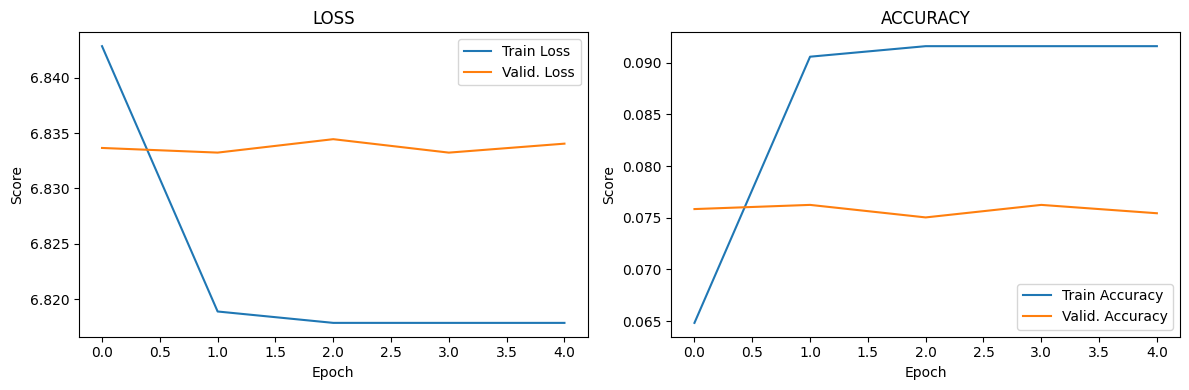

In [ ]:
plot_performance(results)

### NEXT ROUND: Retrain the model with frozen layers

In [ ]:
FROZEN_RESULTS = []
for idx, m in enumerate([model_freeze_block1, model_freeze_block12]):
    print("id: {}".format(idx))
    trainable_model_params = [p for p in m.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(trainable_model_params, lr=LEARNING_RATE)

    new_results = fit(model=m, epoch=EPOCH, train_loader=train_loader, val_loader=val_loader)
    FROZEN_RESULTS.append(new_results)

id: 0


Loss:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 6.821, Validation loss: 6.820, Validation accuracy: 8.998


Loss:   0%|          | 0/12 [00:00<?, ?it/s]

### Examine the difference in both accuracy and loss

In [ ]:
plot_performance(FROZEN_RESULTS[0])

In [ ]:
plot_performance(FROZEN_RESULTS[1])

In [ ]:
# [ PERTANYAAN ]
# TODO: Dengan 5 iterasi yang sama pada training, mengapa Transfer Learning dengan layer yang di-freeze lebih buruk di akurasi akhir?

Mengapa hal tersebut dapat terjadi, dikarenakan:

1.) **Pembekuan Layer Membatasi Kapasitas Belajar pada Fitur Khusus Data Baru**
- Dalam teknik Transfer Learning, ketika layer awal (*lower layers*) dibekukan, maka model hanya akan melatih parameter pada layer terakhir atau pada beberapa layer teratasnya. Layer-layer awal pada model *pre-trained* memiliki representasi fitur dari dataset yang model tersebut dilatih sebelumnya (misalnya, ImageNet), bukan dari dataset yang sedang digunakan untuk *training* saat ini.
- Ketika layer-layer ini dibekukan, model tidak dapat belajar untuk menyesuaikan fitur-fitur awal terhadap dataset baru secara optimal. Hal ini mengakibatkan representasi fitur yang kurang relevan untuk data baru dan dapat menyebabkan akurasi akhir yang lebih rendah (menurun).
2.) **Model Terbatas dalam Menyesuaikan Diri terhadap Pola dan Variasi Data Baru**
- Dataset baru mungkin memiliki pola atau variasi yang berbeda dari data yang digunakan untuk melatih model *pre-trained*. Dimana, ketika layer-layer dibekukan, model akan menjadi kurang fleksibel dalam menyesuaikan fitur-fitur awal dengan pola atau distribusi unik dari dataset baru, dikarenakan hanya beberapa layer terakhir yang disesuaikan selama pelatihan berlangsung.
- Misalnya, jika dataset saat ini memiliki variasi warna atau tekstur yang berbeda dibandingkan dengan dataset awal, maka model mungkin tidak akan dapat menangkap pola baru tersebut dengan baik karena fitur yang dihasilkan oleh layer awal tetap tidak berubah.
3.) **Terbatasnya Proses Optimalisasi berdasarkan Feedback Training**
- Selama *training*, *backpropagation* hanya memperbarui bobot (weight) pada layer yang tidak dibekukan. Pembekuan layer awal akan membuat model kehilangan kesempatan untuk mengoptimalkan semua parameter berdasarkan *feedback* dari data training baru.
- Dengan hanya melatih sebagian layer (misalnya, hanya layer terakhir), kapasitas adaptasi model terhadap dataset baru menjadi terbatas, sehingga model akan kurang optimal dalam mengklasifikasikan data baru, terutama pada dataset yang kompleks atau berbeda dari data *pre-trained*.

---

Analisis berdasarkan tugas yang dikerjakan, dapat dilihat bahwa hanya layer input atau layer tertentu yang diubah untuk menerima input *grayscale* atau menyesuaikan output dengan jumlah kelas baru, tetapi sebagian besar fitur utama dari model (ResNet, DenseNet, atau ViT) masih tetap dibekukan.

Karena layer awal tidak diperbarui, maka fitur-fitur yang dihasilkan oleh model mungkin tidak sesuai untuk tugas klasifikasi dengan dataset baru ini, dan model tidak memiliki cukup fleksibilitas untuk mempelajari pola baru, yang mengarah pada akurasi akhir yang menjadi lebih rendah.

---

**KESIMPULAN**<br>
Secara keseluruhan, Transfer Learning dengan layer yang di-***freeze*** akan cenderung lebih efektif pada tugas-tugas yang mirip dengan dataset asli dari model *pre-trained*. Namun, untuk dataset yang berbeda atau membutuhkan adaptasi lebih besar, membekukan layer dapat membatasi kinerja akhir model. Jika dataset yang digunakan memiliki karakteristik yang berbeda, maka dengan membuka beberapa layer awal atau menggunakan jumlah *epoch* yang lebih tinggi mungkin dapat membantu meningkatkan akurasi akhir.

In [ ]:
# [ PERTANYAAN ]
# TODO: Mengapa semakin banyak layer yang di-freeze, semakin rendah akurasi model di awal iterasi (epoch)?

Mengapa hal tersebut dapat terjadi, dikarenakan:

1.) **Fitur Dasar yang Diperoleh tidak Sepenuhnya Cocok untuk Data Baru**
- Model *pre-trained* seperti ResNet, DenseNet, atau ViT dilatih pada dataset besar seperti **ImageNet**, yang mana memiliki distribusi dan karakteristik khusus. Ketika kami menggunakan model tersebut untuk data baru, maka pada layer awal hingga menengah di dalam model telah mempelajari fitur dasar dari dataset asal (misalnya, pola, tepi, dan tekstur), tetapi fitur ini mungkin tidak sepenuhnya sesuai dengan kebutuhan klasifikasi data baru yang disajikan.
- Ketika semakin banyak layer yang dibekukan, maka model akan kurang mampu untuk menyesuaikan representasi fitur yang sesuai untuk dataset baru karena hanya layer yang tidak dibekukan yang dapat dipelajari ulang dan disesuaikan. Hal ini mengakibatkan akurasi rendah pada awal *epoch* karena model masih berusaha mengadaptasi diri dengan data baru menggunakan fitur yang mungkin tidak cukup spesifik.
2.) **Pembekuan Layar Membatasi Kemampuan Adaptasi pada Tahap Awal**
- Pada tahap awal pelatihan, model membutuhkan fleksibilitas untuk melakukan penyesuaian pada representasi fitur yang sesuai dengan karakteristik data barunya. Semakin banyak layer yang dibekukan, maka akan semakin terbatas juga kemampuan model dalam melakukan penyesuaian awal ini, terutama pada fitur-fitur dasar yang terbentuk pada layer awal.
- Hal ini dapat menyebabkan model akan lebih bergantung pada lapisan akhir (misalnya, layer *classifier* atau *fully connected*) untuk mengatasi perbedaan antara dataset asli dan dataset baru, yang tidak cukup untuk menghasilkan akurasi yang baik pada *epoch* pertama.

---

Analisis berdasarkan tugas yang telah dikerjakan sebelumnya, dapat diperhatikan bahwa kami membekukan beberapa layer tergantung dari pilihan model yang akan digunakan (misalnya, ResNet, DenseNet, atau ViT). Akibatnya, ketika layer-layer ini dibekukan, model tidak dapat memodifikasi representasi fitur yang ada pada layer awal. Hal ini akan menyebabkan ***underfitting*** pada awal pelatihan, yang tercermin dalam akurasi yang rendah.

Dimana, hanya layer akhir yang dapat melakukan penyesuaian terhadap dataset baru, tetapi dikarenakan layer akhir ini terbatas kemampuannya dalam membentuk fitur mendasar, maka model akan mengalami kesulitan dalam mengenali pola yang spesifik terhadap data baru.

---

**KESIMPULAN**<br>
Secara keseluruhan, dapat disimpulkan bahwa semakin banyak layer yang dibekukan, maka akan semakin terbatas juga kemampuan model untuk beradaptasi dengan data baru pada tahap awal pelatihan. Akibatnya, model cenderung memiliki **akurasi yang rendah** pada **epoch awal** karena hanya layer akhir yang dapat disesuaikan, yang mana akan kurang efektif untuk menutupi perbedaan karakteristik data baru. Mungkin, dengan membuka lebih banyak layer untuk pelatihan ulang, model akan dapat mempelajari fitur-fitur yang lebih relevan sejak awal pelatihan, sehingga secara tidak langsung dapat meningkatkan akurasi di awal *epoch*.


### Examine the difference in the execution time

In [ ]:
print("When all layers were TRAINABLE: {:.3f}s.".format(results["exc_time"]))
print("Only 'denseblock1' was FROZEN: {:.3f}s.".format(FROZEN_RESULTS[0]["exc_time"]))
print("Only 'denseblock1' and 'denseblock2' wwere FROZEN: {:.3f}s.".format(FROZEN_RESULTS[1]["exc_time"]))

In [ ]:
# [ PERTANYAAN ]
# TODO: Mengapa semakin banyak layer yang di-freeze, semakin cepat waktu training dan validasinya?

Mengapa hal tersebut dapat terjadi, dikarenakan:

1.) **Layer yang Dibekukan tidak Diperbarui Selama Proses Training**
- Saat layer dibekukan (*freeze*), parameter di dalam layer tersebut tidak diperbarui selama proses *training* berlangsung. Hal ini berarti proses *backpropagation* tidak akan menghitung atau mengoptimalkan gradien pada layer tersebut, yang mana akan mengurangi jumlah komputasi yang diperlukan.
- Pada pekerjaan sebelumnya, kami telah melakukan pembekuan pada beberapa bagian model *pre-trained*, seperti ResNet atau DenseNet, dengan hanya mengizinkan layer terakhir (output) yang dioptimalkan. Hal ini secara signifikan akan mengurangi jumlah parameter yang dihitung gradiennya, sehingga waktu pelatihan menjadi lebih singkat.
2.) **Mengurangi Beban Komputasi pada Proses Forward dan Backward Pass**
- Setiap kali data melewati model, *forward pass* akan menghitung keluaran berdasarkan parameter yang ada. Kemudian, pada layer yang dibekukan, nilai parameternya tidak akan berubah, sehingga waktu yang dihabiskan untuk mengalirkan data melalui layer ini relatif lebih cepat karena tidak perlu melakukan penyimpanan informasi tambahan untuk *gradient tracking*.
- Dalam *backward pass*, layer yang dibekukan tidak memerlukan perhitungan gradien, yang mana secara signifikan akan mengurangi beban komputasi, terutama pada model yang menggunakan banyak parameter.
3.) **Mengurangi Penggunaan Memori GPU/CPU Selamat proses Training**
- Pembekuan layer juga dapat mengurangi penggunaan memori karena informasi terkait gradien hanya perlu disimpan untuk layer yang tidak dibekukan. Pada model besar seperti ResNet atau DenseNet, layer awal sering kali memiliki jumlah parameter yang besar. Dengan membekukan layer-layer tersebut, maka kami dapat mengurangi kebutuhan memori selama pelatihan.
- Hal ini memungkinkan proses pelatihan menjadi berlangsung lebih cepat, karena manajemen memori dan komputasi menjadi lebih efisien.

---

Analisis berdasarkan tugas yang telah dikerjakan sebelumnya, dapat diperhatikan bahwa hanya layer terakhir atau beberapa layer teratas yang diizinkan untuk diperbarui selama *training*. Ketika model hanya melatih sebagian kecil dari layer, khususnya pada layer akhir, model tidak perlu untuk melakukan perhitungan gradien dan update parameter pada layer awal, yang mana akan menyumbang pengurangan waktu pada komputasi.

Pembekuan layer pada model seperti ResNet, DenseNet, atau ViT memanfaatkan representasi fitur yang sudah dipelajari dari dataset asli, sehingga hanya perlu melatih layer akhir untuk mengadaptasi klasifikasi terhadap dataset baru. Hal ini secara tidak langsung akan mempercepat keseluruhan proses training.

---

**KESIMPULAN**<br>
Secara keseluruhan, semakin banyak layer yang dibekukan, maka akan semakin sedikit parameter yang harus dihitung dan dioptimalkan selama *training*. Dengan mengurangi beban komputasi pada layer yang tidak perlu diperbarui, waktu yang dibutuhkan untuk *training* dan validasi berkurang secara signifikan. Pembekuan layer ini memberikan keuntungan dalam waktu eksekusi, terutama pada kasus di mana penyesuaian fitur awal dari model *pre-trained* tidak diperlukan.


### Scoring
Total `#TODO` = 12
<br>Checklist:

- [ ] Ubah susunan input layer DenseNet dengan memanggil create_conv2d()
- [ ] Ubah output layer DenseNet dengan 10 kelas
- [ ] Ubah susunan input layer ViT dengan memanggil create_conv2d()
- [ ] Ubah output layer ViT dengan 10 kelas
- [ ] Tentukan nilai batch size
- [ ] Tentukan nilai learning rate
- [ ] Tentukan loss function (untuk multi-classification)
- [ ] Isi parameter dengan "resnet" untuk ResNet18, atau "densenet" untuk DenseNet121, dan "vit" untuk Vision Transformer.
- [ ] Panggil model, lalu tentukan besaran epoch, train data loader, dan validation data loader
- [ ] PERTANYAAN: Dengan 5 iterasi yang sama pada training, mengapa Transfer Learning dengan layer yang di-freeze lebih buruk di akurasi akhir?
- [ ] PERTANYAAN: Mengapa semakin banyak layer yang di-freeze, semakin rendah akurasi model di awal iterasi (epoch)?
- [ ] PERTANYAAN: Mengapa semakin banyak layer yang di-freeze, semakin cepat waktu training dan validasinya?

### Additional readings
* ResNet: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
* DenseNet: https://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf
* Vision Transformer (ViT): https://arxiv.org/pdf/2010.11929.pdf
* MNIST Classification w/ PyTorch (Beginner): https://www.kaggle.com/code/amsharma7/mnist-pytorch-for-beginners-detailed-desc

### Copyright © 2024 Startup Campus, Indonesia
* Prepared by **Nicholas Dominic, M.Kom.** [(profile)](https://linkedin.com/in/nicholas-dominic)
* You may **NOT** use this file except there is written permission from PT. Kampus Merdeka Belajar (Startup Campus).
* Please address your questions to mentors.